# Convection Diffusion Equation SUPG
We consider the 1D-convection diffusion in order to apply SUPG method for solving it. The boundary value problem for 1D - convection diffusion is
given by:
$$\epsilon u_{xx}+\beta u_x=0$$
where $x \in [0,1]$ , with boundary conditions $u(0) = 0, u(1) = 1$
Figure below shows the exact solution along the Galerkin and SUPG solutions withe $\epsilon=0.005$, and $\beta=1$


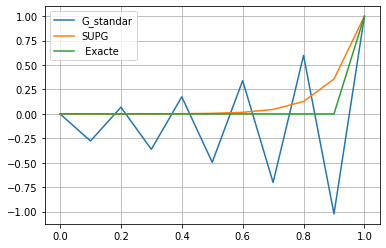

In [1]:
#Classic Finite Element

import numpy as np
import matplotlib.pyplot as plt
from math import cos,pi,exp
a=0#float(input("donner la valeur de a ="))
b=1#float(input("donner la valeur de b ="))
N=10#int(input("donner la valeur de N ="))
h=(b-a)/(N+1)
c=1
T=h/c
ep=0.005
r=1/(exp(1/ep)-1)
exact = lambda x: -r+r*exp(x/ep)
x=np.linspace(a,b,N+1)
f=[exact(e) for e in x]
L=np.zeros([N+1,N+1])
for i in range(N):    
    L[i][i+1]=1/2
    L[i+1][i]=-1/2
L[0][0]=-1/2  
L[N][N]=1/2  
S=np.zeros([N+1,N+1])
for i in range(N):
    S[i][i]=2/h
for i in range(N):    
    S[i][i+1]=-1/h
    S[i+1][i]=-1/h 
S[0][0]=1/h      
S[N][N]=1/h
S1=np.zeros((N+1,1))
S2=np.zeros((N+1,1))
G=np.dot(ep,S)+c*L
G[0,:]=0
G[0,0]=1
G[N,:]=0
G[N,N]=1
S1[0]=0
S1[N]=1
fnew=list(np.linalg.solve(G,S1))
G2=np.dot(ep+T*c*c,S)+c*L
G2[0,:]=0
G2[0,0]=1
G2[N,:]=0
G2[N,N]=1
S2[0]=0
S2[N]=1
fnew2=list(np.linalg.solve(G2,S2))
plt.plot(x,fnew,label='G_standar')
plt.plot(x,fnew2,label='SUPG')
plt.plot(x,f,label=' Exacte')
plt.legend()
plt.grid()

In [11]:
# needed imports
from numpy import  zeros, ones, linspace, zeros_like, asarray
import numpy as np
from math import cos,pi,exp
from matplotlib import pyplot as plt
from Functions1    import elements_spans  # computes the span for each element
from Functions1    import make_knots      # create a knot sequence from a grid
from Functions1   import quadrature_grid # create a quadrature rule over the whole 1d grid
from Functions1    import basis_ders_on_quad_grid # evaluates all bsplines and their derivatives on the quad grid
from Gauss_Legendre import gauss_legendre
from Functions1   import plot_field_1d # plot a solution for 1d problems
from IPython import display

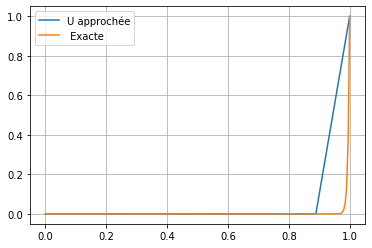

In [12]:
#Finite Element spline
def assemble_stiffnessM(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_x * bj_x) * wvol

                matrix[i1, j1]  += v
    # ...

    return matrix 
def assemble_stiffnessN(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]

    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_0 * bj_x) * wvol

                matrix[i1, j1]  += v
    # ...

    return matrix      
# ...
    # ... Assembly procedure for the rhs


p=1 
ep=0.005
c=1
ne = 10  # number of elements
r=1/(exp(1/ep)-1)
exact = lambda x: -r+r*exp(x/ep)
x=np.linspace(0,1,200)
f=[exact(e) for e in x]
grid  = linspace(0., 1., ne+1)
knots = make_knots(grid, p, periodic=False)
spans = elements_spans(knots, p)    
nelements = len(grid) - 1
nbasis    = len(knots) - p - 1

# we need the value a B-Spline and its first derivative
nderiv = 1

# create the gauss-legendre rule, on [-1, 1]
u, w = gauss_legendre( p )

# for each element on the grid, we create a local quadrature grid
points, weights = quadrature_grid( grid, u, w )

# for each element and a quadrature points, 
# we compute the non-vanishing B-Splines
basis = basis_ders_on_quad_grid( knots, p, points, nderiv )
stiffnessM = zeros((nbasis, nbasis))
stiffnessM = assemble_stiffnessM(nelements, p, spans, basis, weights, points, matrix=stiffnessM)
stiffnessN = zeros((nbasis, nbasis))
stiffnessN = assemble_stiffnessN(nelements, p, spans, basis, weights, points, matrix=stiffnessN)
exact = lambda x: 1/(16*pi*pi)*cos(4*pi*x)-1/(16*pi*pi)
#exact = lambda x: -exp(x)+(exp(1)-1)*x+1  
rhs = zeros(nbasis)
#rhs = assemble_rhs(f, nelements, p, spans, basis, weights, points, rhs=rhs)
# apply homogeneous dirichlet boundary conditions
rhs = rhs[1:-1]
stiffnessM = stiffnessM[1:-1, 1:-1]
stiffnessN = stiffnessN[1:-1, 1:-1]
from scipy.sparse.linalg import cg
u, info = cg( ep*stiffnessM+c*stiffnessN, rhs, tol=1e-6, maxiter=5000 )
u = [0.] + list(u) + [1.]
u = asarray(u)
plot_field_1d(knots, p, u, nx=10)
plt.plot(x,f,label=' Exacte')
plt.legend()

For spline it is always stable by cons standard we need SUPG to stabilize it

# Transport Equation SUPG
Now we will try to stabilize the transport problem by SUPG then we consider the following simple transport equation 1D:
$$\left\{
\begin{array}{rrrrr}
\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x}&=&0&\text{in}\quad\Omega,\\
u(t=0,x)&=&u_{0}(x)& \\
u(t,a)&=&0&
\end{array}
\right.$$
where $\Omega=[-5,5]$, $c=1$ and 
$$ 
u_{0}(x)=  \left\{
\begin{array}{ll}
5 \ \ \  \ \ si \ \ -1 \leq x \leq 1  \\ \\
0 \ \ \ \ \ sinon. \\
\end{array}
\right.
$$


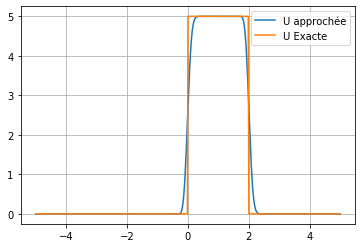

In [14]:
#Classic Finite Element 

a=-5#float(input("donner la valeur de a ="))
b=5#float(input("donner la valeur de b ="))
N=500#int(input("donner la valeur de N ="))
c=1#float(input("donner la vitesse c ="))
ht=0.01#float(input("donner le pas de temps ht ="))
Tmax=1#float(input("donner le temps maximal Tmax ="))
h=(b-a)/(N+1)
def U0(x):
    if x>=-1 and x<=1 :
        return 5
    else:
        return 0

def Uexact(t,x,c) :
    return(U0(x-c*t))
x=np.linspace(a,b,N+1)
f=[U0(e) for e in x]
M=np.zeros([N+1,N+1])
for i in range(N):
    M[i][i]=2*h/3
for i in range(N):    
    M[i][i+1]=h/6
    M[i+1][i]=h/6
M[0][0]=h/3  
M[N][N]=h/3   
L=np.zeros([N+1,N+1])
for i in range(N):    
    L[i][i+1]=1/2
    L[i+1][i]=-1/2
L[0][0]=-1/2  
L[N][N]=1/2  
R=np.zeros([N+1,N+1])
for i in range(N):    
    R[i][i+1]=-1/2
    R[i+1][i]=1/2
R[0][0]=-1/2  
R[N][N]=1/2 
S=np.zeros([N+1,N+1])
for i in range(N):
    S[i][i]=2/h
for i in range(N):    
    S[i][i+1]=-1/h
    S[i+1][i]=-1/h 
S[0][0]=1/h      
S[N][N]=1/h
z=0 
i=1
T=h/c
while z<=Tmax:
    G=M+c*T*R+np.dot(ht,c*c*T*S+L)
    G[0,:]=0
    G[0,0]=1
    S1=np.dot(M+c*T*R,f[0:N+1])
    S1[0]=0
    fnew=list(np.linalg.solve(G,S1))
    o=[Uexact(z,e,c) for e in x]
    display.clear_output(wait=True)
    plt.plot(x,fnew,label='U approchée')
    plt.plot(x,o,label='U Exacte')
    #plt.title(' dt=%1.2f ' %ht  )
    plt.legend()
    plt.grid()
    plt.pause(0.005)
    f=fnew
    z=z+ht

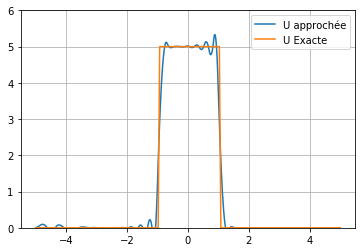

In [10]:
#Finite Element Spline
# ... assembling the stiffness matrix using stencil forms
def assemble_stiffnessM(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_0 * bj_0) * wvol

                matrix[i1, j1]  += v
    # ...

    return matrix    
# ...
    # ... Assembly procedure for the rhs
def assemble_stiffnessN(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    h=20/(1000)
    c=1
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_0 * bj_x) * wvol

                matrix[i1, j1]  += v
    # ...

    return matrix    
def assemble_stiffnessR(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    h=10/(500)
    c=1
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        Pek=1/3*h*c/(2*ie1+1)
        if Pek<1:
            xpek=Pek
        else:
            xpek=1
        T=h/(2*c)*xpek    
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_x * bj_0) * wvol

                matrix[i1, j1]  += T*v
    # ...

    return matrix   
def assemble_stiffnessS(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1       = nelements
    p1        = degree
    spans_1   = spans
    basis_1   = basis
    weights_1 = weights
    points_1  = points
    
    k1 = weights.shape[1]
    h=10/500
    c=1
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        Pek=1/3*h*c/(2*ie1+1)
        if Pek<1:
            xpek=Pek
        else:
            xpek=1
        T=h/(2*c)*xpek
        i_span_1 = spans_1[ie1]
        for il_1 in range(0, p1+1):
            for jl_1 in range(0, p1+1):
                i1 = i_span_1 - p1 + il_1
                j1 = i_span_1 - p1 + jl_1

                v = 0.0
                for g1 in range(0, k1):
                    bi_0 = basis_1[ie1, il_1, 0, g1]
                    bi_x = basis_1[ie1, il_1, 1, g1]                    

                    bj_0 = basis_1[ie1, jl_1, 0, g1]
                    bj_x = basis_1[ie1, jl_1, 1, g1]                    

                    wvol = weights_1[ie1, g1]

                    v += (bi_x * bj_x) * wvol

                matrix[i1, j1]  +=T*v
    # ...

    return matrix     
# ...

def U0(x):
    if x>=-1 and x<=1 :
        return 5
    else:
        return 0    
def plot_exact(knots,degree,t,c,nx=101,color='r'):
    def Uexact(t,x,c) :
        return(U0(x-c*t))
    xmin = knots[degree]
    xmax = knots[-degree-1]

    xs = np.linspace(xmin, xmax, nx)
    u=[Uexact(t,e,c) for e in xs]
    plt.plot(xs, u,label='U Exacte')
    plt.legend()
  
   
c=1    
p=2 
ne = 65 # number of elements

grid  = linspace(-5., 5., ne+1)
X  = linspace(-5., 5., ne+p)
f=[U0(e) for e in X]
knots = make_knots(grid, p, periodic=False)
spans = elements_spans(knots, p)    
nelements = len(grid) - 1
nbasis    = len(knots) - p - 1

# we need the value a B-Spline and its first derivative
nderiv = 1
ht=0.01
Tmax=0.05
# create the gauss-legendre rule, on [-1, 1]
u, w = gauss_legendre( p )

# for each element on the grid, we create a local quadrature grid
points, weights = quadrature_grid( grid, u, w )

# for each element and a quadrature points, 
# we compute the non-vanishing B-Splines
basis = basis_ders_on_quad_grid( knots, p, points, nderiv )
stiffnessM = zeros((nbasis, nbasis))
stiffnessN = zeros((nbasis, nbasis))
stiffnessR = zeros((nbasis, nbasis))
stiffnessS = zeros((nbasis, nbasis))
stiffnessM = assemble_stiffnessM(nelements, p, spans, basis, weights, points, matrix=stiffnessM)
stiffnessN = assemble_stiffnessN(nelements, p, spans, basis, weights, points, matrix=stiffnessN)
stiffnessR = assemble_stiffnessR(nelements, p, spans, basis, weights, points, matrix=stiffnessR)
stiffnessS = assemble_stiffnessS(nelements, p, spans, basis, weights, points, matrix=stiffnessS)
#f = lambda x: exp(x)
#exact = lambda x: -exp(x)+(exp(1)-1)*x+1  

# apply homogeneous dirichlet boundary conditions
z=0
#stiffness = stiffness[1:-1, 1:-1]
#stiffness2 = stiffness2[1:-1, 1:-1]

while z<=Tmax:
    G=stiffnessM+stiffnessR+np.dot(ht,stiffnessS+stiffnessN)
    G[0,:]=0
    G[0,0]=1
    S=np.dot(stiffnessM+stiffnessR,f[:])
    S[0]=0
    from scipy.sparse.linalg import cg
    unew, info = cg( G, S, tol=1e-6, maxiter=5000 )
    unew = list(unew) 
    unew = asarray(unew)
    display.clear_output(wait=True)
    plot_field_1d(knots, p, unew, nx=500)
    plot_exact(knots,p,z,c,nx=200,color='r')
    plt.ylim([0,6])
    plt.pause(0.005)
    f=unew
    z=z+ht

We notice that the SUPG is effective for classic finite element but does not work with FES

# Transport Equation Least Squares 

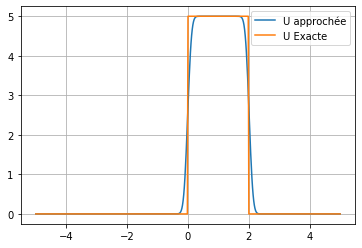

In [17]:
#Classic Finite Element
a=-5#float(input("donner la valeur de a ="))
b=5#float(input("donner la valeur de b ="))
N=500#int(input("donner la valeur de N ="))
c=1#float(input("donner la vitesse c ="))
h=(b-a)/N
Tmax=1
ht=0.01
#...............
def U0(x):
    if x>=-1 and x<=1 :
        return 5
    else:
        return 0

def Uexact(t,x,c) :
    return(U0(x-c*t))
x=np.linspace(a,b,N+1)
f=[U0(e) for e in x]
M=np.zeros([N,N])
for i in range(N):
    M[i][i]=2*(c*c)/h
for i in range(N-1):    
    M[i][i+1]=-(c*c)/h
    M[i+1][i]=-(c*c)/h    
M[N-1][N-1]=(c*c)/h 
L=np.zeros([N,N])
for i in range(N-1):    
    L[i][i+1]=(-c)/2
    L[i+1][i]=c/2      
L[N-1][N-1]=c/2

#.........
z=0 
while z<=Tmax:
    G=L+np.dot(ht,M)
    S=np.dot(L,f[1:N+1])
    fnew=list(np.linalg.solve(G,S))
    o=[Uexact(z,e,c) for e in x]
    fnew.insert(0,0)
    display.clear_output(wait=True)
    plt.plot(x,fnew,label='U approchée')
    plt.plot(x,o,label='U Exacte')
    plt.legend()
    plt.grid()
    plt.pause(0.005)
    f=fnew
    z=z+ht